<font size="5">Variational Bayes time series clustering and Generative model</font>

In [10]:
import warnings
warnings.filterwarnings('ignore')

import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be to cluster the time series into different hidden states based on their mean and covariance, then view synthetic data sampled from each state in isolation using two different methods: a GaussianMultivariate instance (copula) and sampling from the BayesianGaussianMixture model fit only on a single state. 

In [11]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [12]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_subset = pd.DataFrame()

for sym in assetlist: 
    m6_subset[sym] = m6[m6['symbol'] == sym]['price'].values

Log return of each asset.  

In [13]:
m6_subset = m6_subset.apply(np.log).apply(np.diff).dropna()
print(m6_subset)

          IEF       GSG       IXN
0   -0.001353  0.007295  0.003029
1    0.002047  0.003110  0.007333
2   -0.004270  0.004132 -0.030381
3   -0.007710  0.013822  0.004786
4    0.000273 -0.002036 -0.007351
..        ...       ...       ...
193 -0.003539 -0.006549  0.016234
194  0.006638 -0.017230  0.011501
195  0.003409 -0.027102 -0.023824
196  0.022192  0.008208  0.078576
197 -0.002082  0.018002  0.022459

[198 rows x 3 columns]


Instantiate a non-parametric clustering model using the dirichlet process. 

In [14]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')
dpgmm_model.fit(m6_subset)

BayesianGaussianMixture(n_components=99)

In [15]:
states = dpgmm_model.predict(m6_subset)
m6_subset['state'] = states 

Visualize the states in isolation using the compare3d function, 

In [16]:
def resample_multivariate_gaussian(M, base_model):
    
    # Get base model mean and covariance 
    
    mean = base_model.means_[M]
    cov = base_model.covariances_[M]
    
    # Resample a specific state to view the mean and covariance characteristics of that state in isolation. First
    # we use the dpgmm model sampling method and then we use the copula sampling method, as a comparison of them. 
    
    state_match = m6_subset[m6_subset['state'] == M].drop(columns=['state']) 
    if len(state_match) <= 1:
        return 
    
    # Get data points only within the current state 
    
    state_match = state_match.rename(columns={
        'IEF':0, 'GSG':1, 'IXN':2
    })
    state_model = mix.BayesianGaussianMixture(n_components=len(state_match), weight_concentration_prior_type='dirichlet_process')
    state_model.fit(state_match)
    
    # Sample from the fitted distribution of matches 
    
    samples, _ = state_model.sample(len(state_match))
    get_col = lambda N: [ s[N] for s in samples ]

    samples_df = pd.DataFrame()
    samples_df[0] = get_col(0) 
    samples_df[1] = get_col(1) 
    samples_df[2] = get_col(2) 
    
    # Fit Copula 

    copula = GaussianMultivariate()
    copula.fit(state_match)
    copula_samples = copula.sample(len(state_match))
    
    # Visualize 
    
    fig,ax=plt.subplots(2)
    
    #sns.lineplot(data=samples_df[0].cumsum(), label='IEF', ax=ax[0])
    #sns.lineplot(data=samples_df[1].cumsum(), label='GSG', ax=ax[0])
    #sns.lineplot(data=samples_df[2].cumsum(), label='IXN', ax=ax[0])
    
    sns.scatterplot(data=samples_df[0], ax=ax[0], color='darkorange', alpha=0.8, s=12, label='IEF')
    sns.scatterplot(data=samples_df[1], ax=ax[0], color='darkorange', alpha=0.5, s=12, label='GSG')
    sns.scatterplot(data=samples_df[2], ax=ax[0], color='black', alpha=0.2, s=12, label='IXN')
    
    sns.scatterplot(data=copula_samples[0], ax=ax[1], color='darkorange', alpha=0.8, s=12, label='IEF')
    sns.scatterplot(data=copula_samples[1], ax=ax[1], color='darkorange', alpha=0.5, s=12, label='GSG')
    sns.scatterplot(data=copula_samples[2], ax=ax[1], color='black', alpha=0.2, s=12, label='IXN')

    ax[0].set_title('Variational Bayes sampler')
    ax[1].set_title('Copula sampler')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f'state {M} empirical mean (IEF) {np.mean(copula_samples[0])}')
    print(f'state {M} empirical mean (GSG) {np.mean(copula_samples[1])}')
    print(f'state {M} empirical mean (IXN) {np.mean(copula_samples[2])}')
    print(f'state {M} empirical skew (IEF) {scipy.stats.skew(copula_samples[0])}')
    print(f'state {M} empirical skew (GSG) {scipy.stats.skew(copula_samples[1])}')
    print(f'state {M} empirical skew (IXN) {scipy.stats.skew(copula_samples[2])}')
    
    compare_3d(state_match, copula_samples)
    compare_3d(state_match, samples_df)

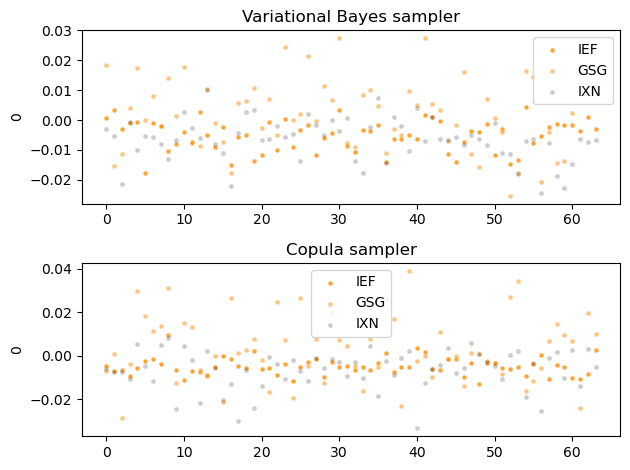

state 1 empirical mean (IEF) -0.0049343308297684066
state 1 empirical mean (GSG) 0.0032178724041629905
state 1 empirical mean (IXN) -0.006690865635054283
state 1 empirical skew (IEF) 0.7812731676916395
state 1 empirical skew (GSG) 0.22093938227942747
state 1 empirical skew (IXN) -0.9089086781449531


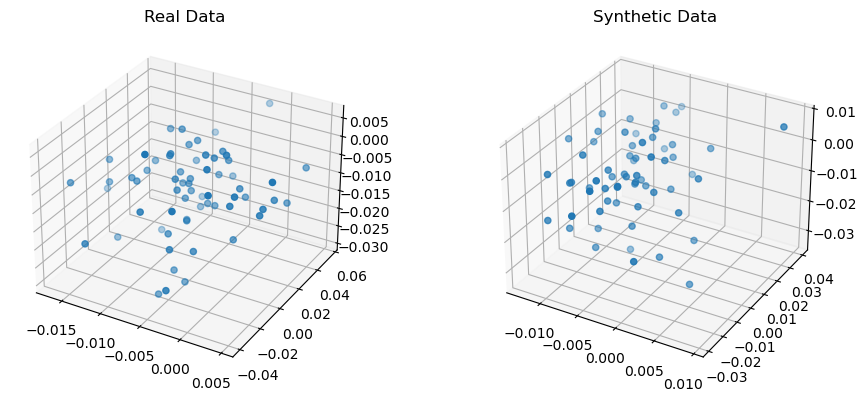

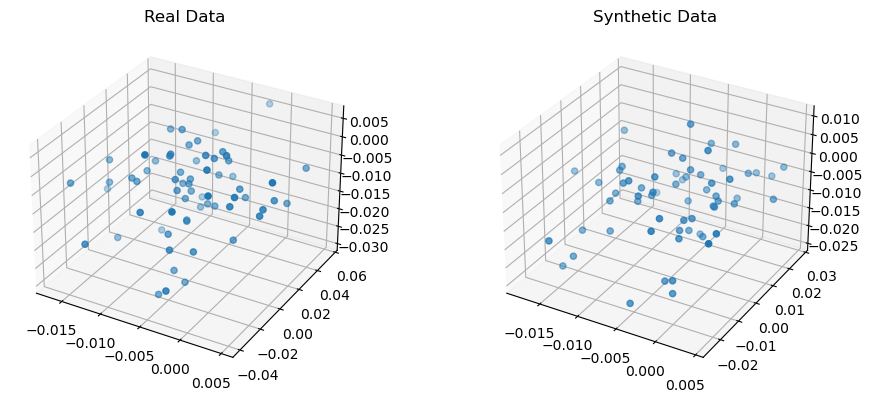

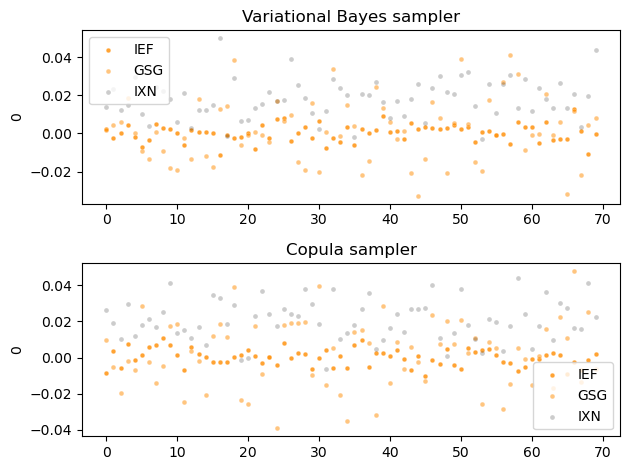

state 8 empirical mean (IEF) 3.69176167065065e-05
state 8 empirical mean (GSG) 0.0020931523131239556
state 8 empirical mean (IXN) 0.020477474191722633
state 8 empirical skew (IEF) -0.01054092571660092
state 8 empirical skew (GSG) -0.031151089715973468
state 8 empirical skew (IXN) 0.00236770734807866


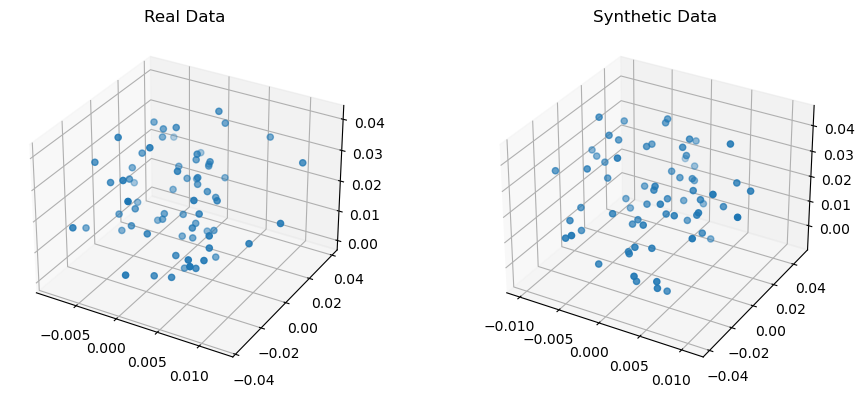

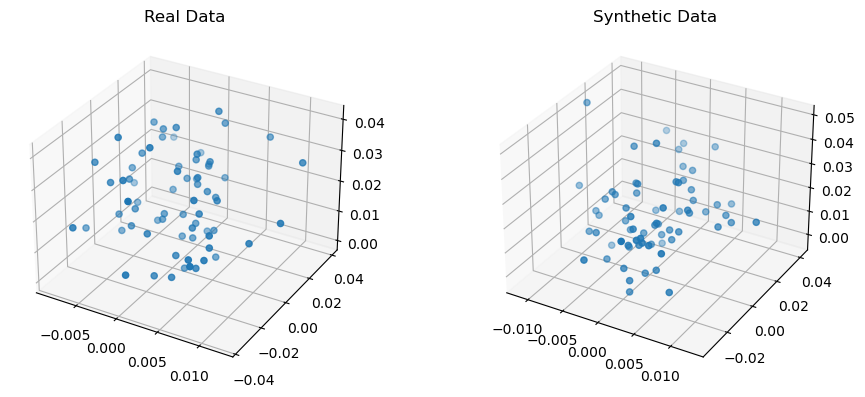

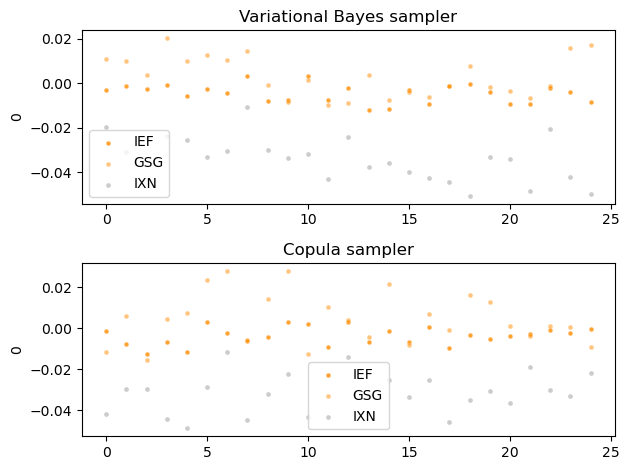

state 3 empirical mean (IEF) -0.003792189447336094
state 3 empirical mean (GSG) 0.004495355724769627
state 3 empirical mean (IXN) -0.031342422465105664
state 3 empirical skew (IEF) -0.16011674088734754
state 3 empirical skew (GSG) 0.35416531494836423
state 3 empirical skew (IXN) 0.056471804463012185


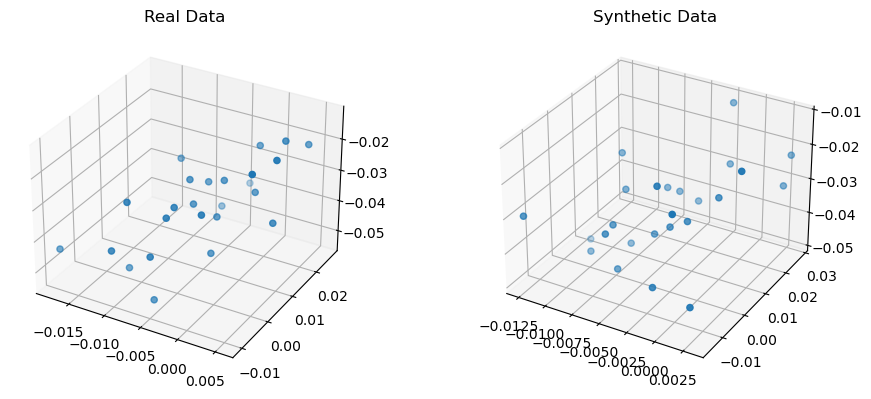

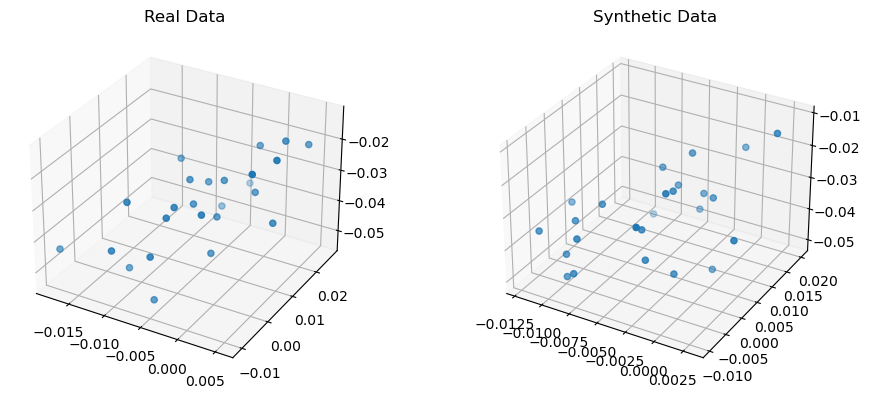

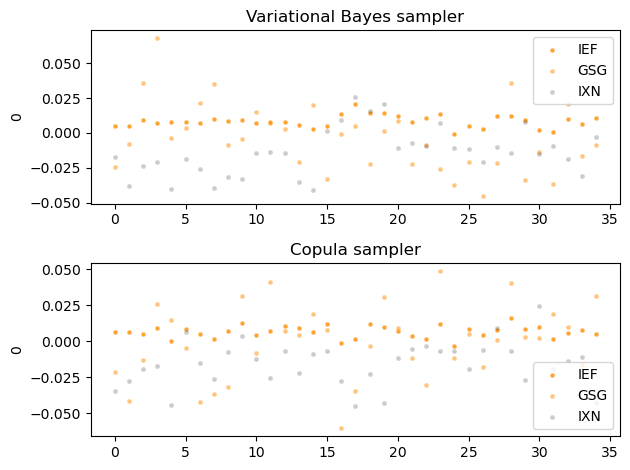

state 9 empirical mean (IEF) 0.006628578445969654
state 9 empirical mean (GSG) -0.0009805804946288342
state 9 empirical mean (IXN) -0.015614928612758866
state 9 empirical skew (IEF) -0.23163295579838747
state 9 empirical skew (GSG) -0.15283689727451966
state 9 empirical skew (IXN) 0.011418137973863486


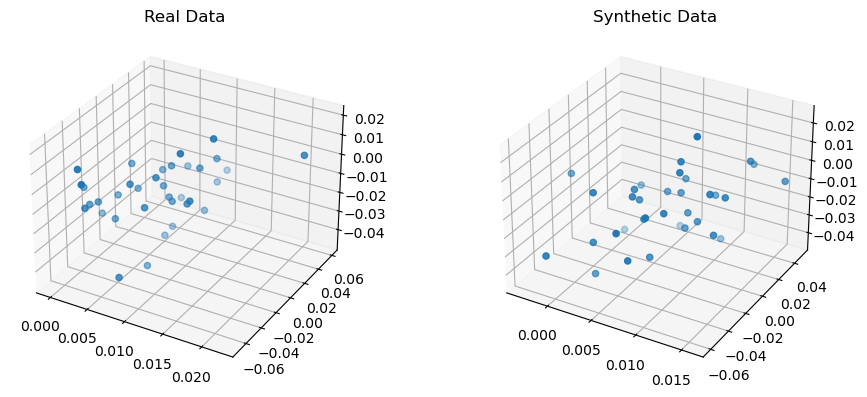

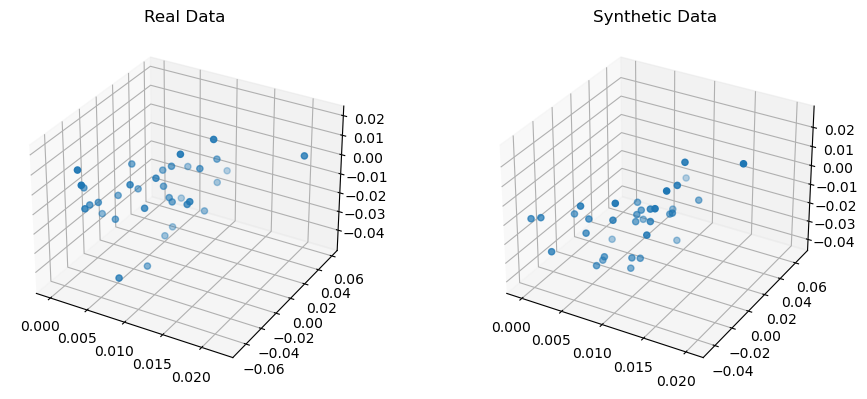

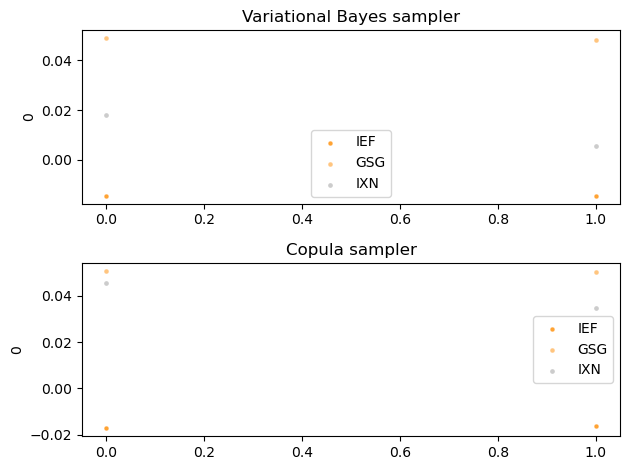

state 4 empirical mean (IEF) -0.016800883582858164
state 4 empirical mean (GSG) 0.05058601725048816
state 4 empirical mean (IXN) 0.04009965425917203
state 4 empirical skew (IEF) 0.0
state 4 empirical skew (GSG) 0.0
state 4 empirical skew (IXN) 0.0


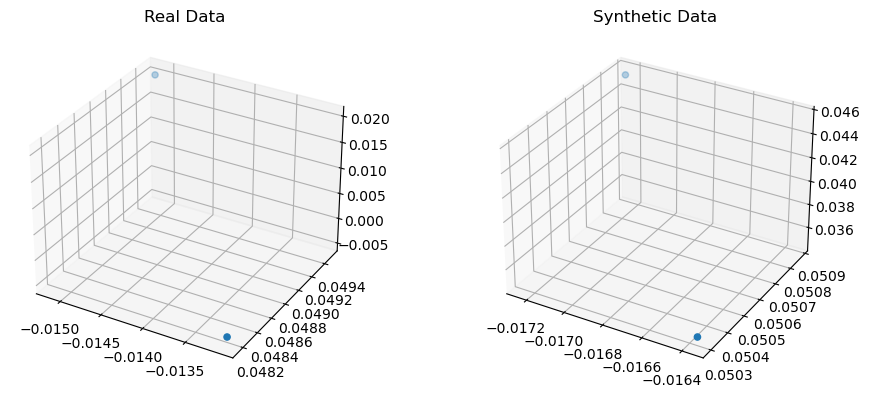

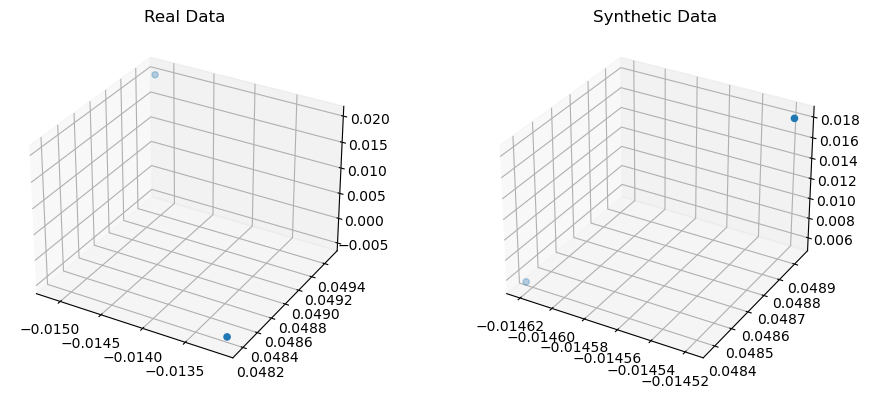

In [17]:
for M in m6_subset['state'].unique():
    resample_multivariate_gaussian(M, dpgmm_model)